In [1]:
import os, time
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, execute, IBMQ
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
from operators.pauli_hamiltonian import PauliHamiltonian
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_histogram


In [2]:
# Get on one of the IBM Q machines
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q-ornl', project='brookhaven')
provider
provider.backends()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>]


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brook

In [3]:
backend = provider.get_backend('ibmq_johannesburg')
backend

<IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>

Status @ 0 seconds
JobStatus.RUNNING
JobStatus.DONE


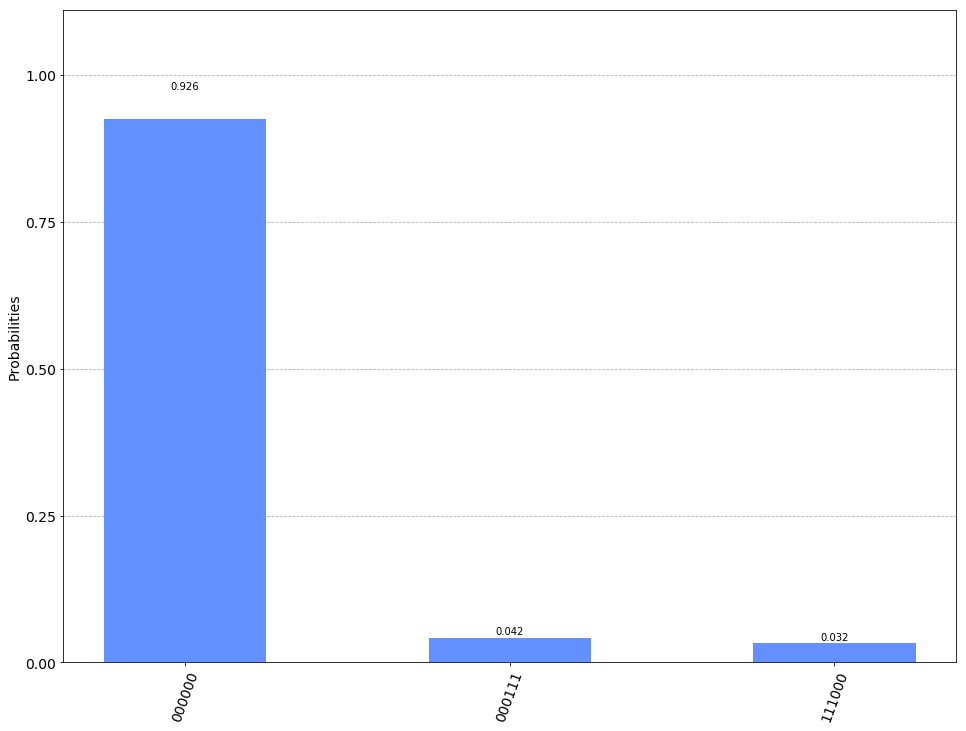

In [51]:
# 2 triangle plaquettes
#backend = BasicAer.get_backend('qasm_simulator')
T = 0.1
H = TrianglePlaquetteHamiltonian(0.5, 1, 2)
# Construct Circuit with n_steps = 20
qr = QuantumRegister(6, 'qr')
cr = ClassicalRegister(6, 'cr')
circ1 = QuantumCircuit(qr, cr)
circ1 = H.trotter_circuit_optimized(circ1, qr, T, 1)
circ1.measure(qr, cr)
job = execute(circ1, backend, shots=1024)
lapse = 0
interval = 30
while job.status() != JobStatus.DONE:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    time.sleep(interval)
    lapse += 1
print(job.status())
result_sim = job.result()
tr_dist2 = result_sim.get_counts(circ1)
plot_histogram(tr_dist2, figsize=(16, 12))

In [50]:
# Measure distances with the two distribution
def KL(p1, p2):
    """
    Compute the D_KL(p1||p2)
    """
    return np.sum(np.where(p2!=0, p1 * np.log(p1 / p2), 0))

def H(p):
    """
    Compute Shannon entropy of p
    """
    return -np.sum(np.where(p != 0, p * np.log(p), 0))

backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ1, backend, shots=1024)
result_sim = job.result()
ideal_dist = result_sim.get_counts(circ1)
p1 = np.fromiter(tr_dist2.values(), float)/1024
p2 = np.fromiter([ideal_dist.get(k, 0) for k in tr_dist2.keys()], float)/1024
print(p1)
print(p2)
print(KL(p1, p2))
print(H(p1))
print(H(p2))

[0.00390625 0.27246094 0.00488281 0.00390625 0.02050781 0.01269531
 0.00683594 0.00488281 0.03808594 0.00585938 0.00585938 0.00390625
 0.02539062 0.00976562 0.046875   0.00195312 0.00390625 0.00195312
 0.00195312 0.00585938 0.01367188 0.00683594 0.00683594 0.00488281
 0.00097656 0.00097656 0.00097656 0.00585938 0.0078125  0.00683594
 0.00195312 0.00097656 0.00292969 0.00585938 0.03417969 0.00292969
 0.03320312 0.00097656 0.03710938 0.01171875 0.0078125  0.05761719
 0.01171875 0.00488281 0.02246094 0.00097656 0.01464844 0.03417969
 0.09863281 0.00292969 0.00292969 0.02246094 0.00878906 0.00390625
 0.0078125  0.00292969 0.00195312 0.00585938 0.01855469]
[0.         0.93066406 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


In [30]:
def dec_to_binary_str(dec, n_dig):
    s = bin(dec).replace("0b", "")
    return '0'*(n_dig - len(s)) +s
print(np.fromiter(tr_dist2.keys(), 'S6')[list(np.where(np.fromiter(tr_dist2.values(), float) > 0.01*1024)[0])])

[b'000000' b'001001' b'001011' b'000001' b'010010' b'010001' b'011000'
 b'010011' b'110000' b'100001' b'111000' b'000011' b'100000' b'001010'
 b'011011' b'010000' b'011001' b'101000' b'000010' b'001000' b'000100'
 b'011010' b'001111' b'000111']


In [29]:
np.where(np.fromiter(tr_dist2.values(), float) > 0.01*1024)[0]

array([ 1,  4,  8,  9, 13, 14, 15, 23, 25, 37, 38, 40, 42, 43, 45, 46, 47,
       49, 51, 52, 55, 58, 61, 62], dtype=int64)

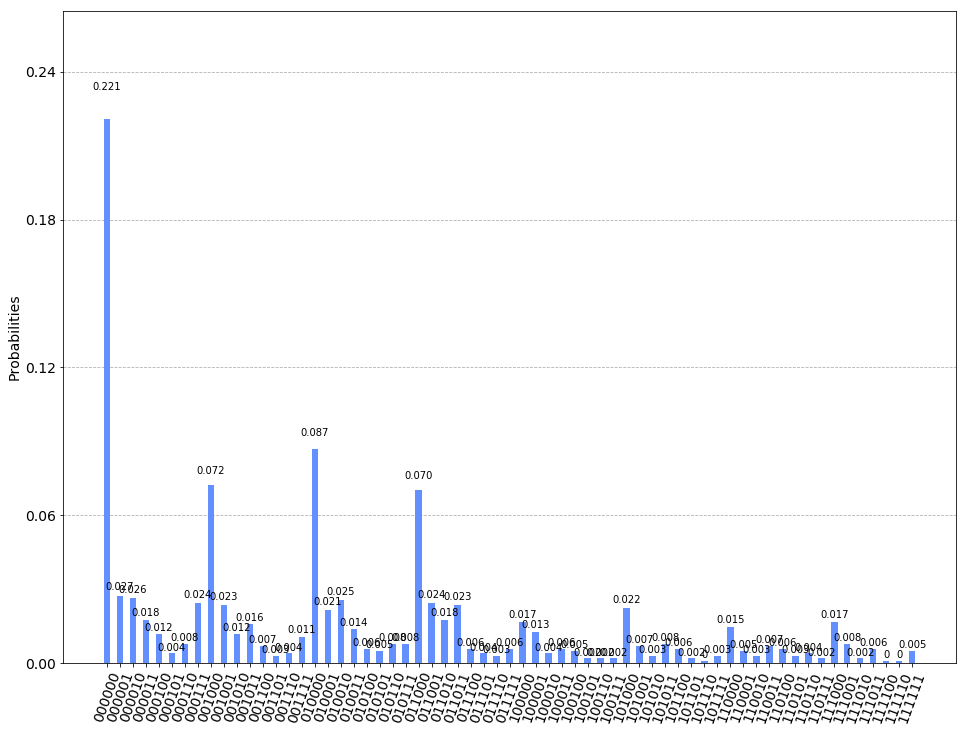

In [32]:
plot_histogram(tr_dist2, figsize=(16, 12))